In [2]:
import os
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torchvision.datasets import MNIST

In [3]:
!pwd

/content


In [4]:
from torchvision.transforms import ToTensor

data_dir = Path("data/mnist")

def download_MNIST_dataset(data_dir : Path) -> None | torch.utils.data.Dataset:

  train_dir = data_dir / "train"
  test_dir = data_dir / "test"
  train_dataset = MNIST(root=train_dir, train=True, download=True, target_transform=None, transform=ToTensor())
  test_dataset = MNIST(root=test_dir, train=False, download=True, target_transform=None, transform=ToTensor())

  return train_dataset, test_dataset


In [5]:
train_dataset, test_dataset = download_MNIST_dataset(data_dir)

100%|██████████| 9912422/9912422 [00:00<00:00, 124567687.09it/s]


Extracting data/mnist/train/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94269022.43it/s]


Extracting data/mnist/train/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37132502.17it/s]

Extracting data/mnist/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/train/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 24053697.94it/s]


Extracting data/mnist/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 124098821.40it/s]

Extracting data/mnist/test/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/test/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109724360.35it/s]


Extracting data/mnist/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35600845.23it/s]

Extracting data/mnist/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/test/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3329929.87it/s]


Extracting data/mnist/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/test/MNIST/raw



In [9]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [15]:
image, label = train_dataset.data[0], train_dataset.targets[0]
image.shape


torch.Size([28, 28])

In [18]:
type(train_dataset.data)

torch.Tensor

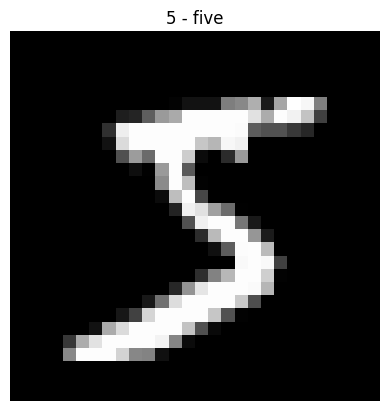

In [17]:
import matplotlib.pyplot as plt

plt.imshow(image.unsqueeze(dim=2), cmap='gray');
plt.title(train_dataset.classes[label])
plt.axis(False);

In [33]:
import random

class_names = train_dataset.classes

def visualize_random_pictures(list_dataset : torch.Tensor, target: torch.Tensor, n: int = 4, seed: int = 82) -> None:
  size = len(list_dataset)
  random.seed(seed)
  plt.figure(figsize=(12, 6))

  for i in range(n):
    randidx = random.randint(0, size)
    image, label = list_dataset[randidx], target[randidx]

    plt.subplot((n // 4) + 1, 4, i + 1)
    plt.imshow(image.unsqueeze(dim = 2), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

  plt.show()

In [55]:
from torch.utils.data import DataLoader
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset ,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset ,
                              batch_size=32,
                              shuffle=True)

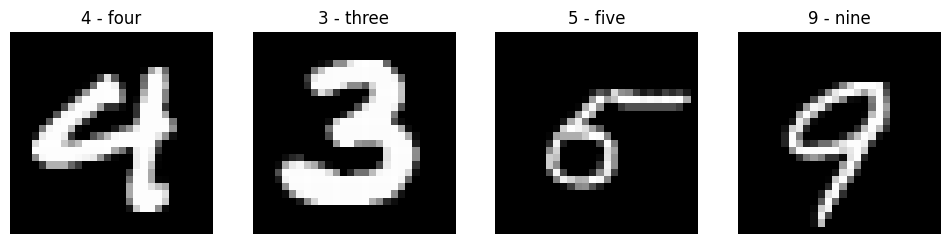

In [34]:
visualize_random_pictures(list_dataset=test_dataset.data,
                           target=test_dataset.targets)

In [142]:
class SimpleAutoencoder(nn.Module):
  def __init__(self, width: int, height: int, latent_dim: int = 64):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=width * height, out_features = 512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features = latent_dim),
        nn.ReLU()
    )


    self.decoder = nn.Sequential(
        nn.Linear(in_features=latent_dim, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features = 512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features = width * height),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(self.encoder(x)).reshape(-1, 1, width, height)

In [143]:
width, height = image.shape
width

28

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = SimpleAutoencoder(width=28, height=28).to(device)

loss_fn_0 = nn.MSELoss()

optimizer_0 = torch.optim.Adam(params=model_0.parameters(), lr=.03)

In [138]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device='cuda') -> float:
  model.train()
  total_loss = 0
  for idx, (X, _) in enumerate(dataloader):
    X = X.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss
    if idx % 400 == 0:
      print(f"Trained on {idx * len(X)}/{len(dataloader.dataset)}")
  total_loss /= len(dataloader)

  print(f"Train Loss: {total_loss:.4f}", end=" | ")
  return total_loss

In [139]:
def test_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device='cuda') -> float:
  model.eval()
  total_loss = 0
  for X, _ in dataloader:
    X = X.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, X)

    total_loss += loss
  total_loss /= len(dataloader)

  print(f"Test Loss: {total_loss:.4f}")
  return total_loss

In [140]:
def train_loop(model: nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               epochs: int = 10,
               device: torch.device = "cuda") -> None:

  start_timer = timer()

  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------\n")

    train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device)
    test_step(model=model,
               dataloader=test_dataloader,
               loss_fn=loss_fn,
               device=device)

  end_timer = timer()
  print(f"Total time train on {device}: {end_timer - start_timer:.4f}")

In [168]:
train_loop(model=model_0,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader ,
            loss_fn=loss_fn_0,
            optimizer=optimizer_0,
            epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
--------

Trained on 0/60000
Trained on 12800/60000
Trained on 25600/60000
Trained on 38400/60000
Trained on 51200/60000
Train Loss: 0.0651 | Test Loss: 0.0652
Epoch: 1
--------

Trained on 0/60000
Trained on 12800/60000
Trained on 25600/60000
Trained on 38400/60000
Trained on 51200/60000
Train Loss: 0.0649 | Test Loss: 0.0650
Epoch: 2
--------

Trained on 0/60000
Trained on 12800/60000
Trained on 25600/60000
Trained on 38400/60000
Trained on 51200/60000
Train Loss: 0.0648 | Test Loss: 0.0648
Epoch: 3
--------

Trained on 0/60000
Trained on 12800/60000
Trained on 25600/60000
Trained on 38400/60000
Trained on 51200/60000
Train Loss: 0.0646 | Test Loss: 0.0647
Epoch: 4
--------

Trained on 0/60000
Trained on 12800/60000
Trained on 25600/60000
Trained on 38400/60000
Trained on 51200/60000
Train Loss: 0.0645 | Test Loss: 0.0645
Epoch: 5
--------

Trained on 0/60000
Trained on 12800/60000
Trained on 25600/60000
Trained on 38400/60000
Trained on 51200/60000
Train Loss: 0.0643 | Test

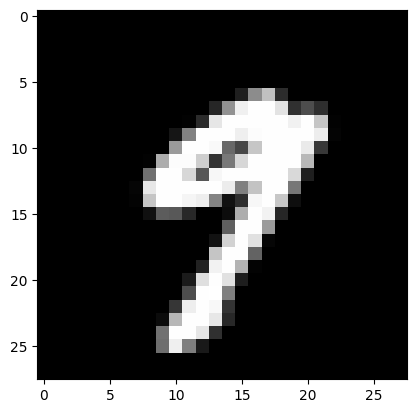

In [172]:
image, _ = test_dataset[20]
plt.imshow(image.permute(1, 2, 0), cmap='gray')

In [173]:
ae_image = model_0(image.unsqueeze(dim = 0).to(device)).cpu().detach().squeeze(dim=0).permute(1, 2, 0)

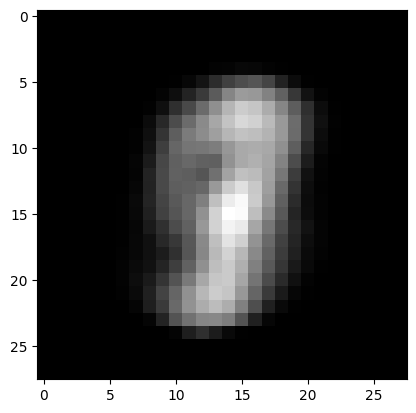

In [174]:
plt.imshow(ae_image, cmap='gray')